In [1]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read CSV
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Assay_Plate_Barcode,sphering,value_95_replicating,Percent_Replicating,Plate_Map_Name,Modality,Images_per_well,Sites-SubSampled,...,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Size_MB,Size_MB_std,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,True,0.200046,57.777778,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476334,0.000144,20.930233,0.303191,2014937
1,MolDev,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,False,0.420650,35.555556,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476334,0.000144,16.279070,0.307224,2014937
2,MolDev,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,True,0.268013,62.222222,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476514,0.000183,20.930233,0.401802,2413350
3,MolDev,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,False,0.338900,47.777778,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476514,0.000183,16.279070,0.411854,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,Plate3_PCO_6ch_4site_10XPA_Crestz,True,0.205121,66.666667,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476631,0.000142,23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO0117059_20X,False,0.628379,20.000000,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,7.954439,0.000583,6.976744,0.772160,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO01177034_20x,True,0.139090,56.666667,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,8.003584,0.000014,18.604651,0.193171,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO01177034_20x,False,0.666818,21.111111,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,8.003584,0.000014,9.302326,0.790813,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,True,0.193787,53.333333,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,7.971628,0.080201,20.930233,0.234702,116595


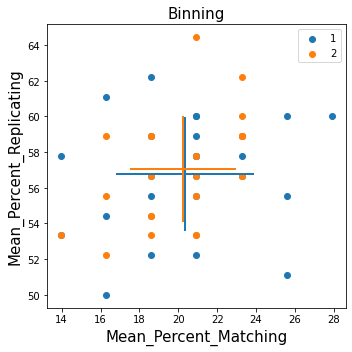

In [4]:
# A

group = "Binning"

df_subset = match_rep_df[(match_rep_df["sphering"] == True) & (match_rep_df["Vendor"] == "PE") & (match_rep_df["Modality"] == "Confocal")]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig, 
    ax_=ax
)
fig.savefig("(A)-rep-vs-match-binning-PE-confocal.png")

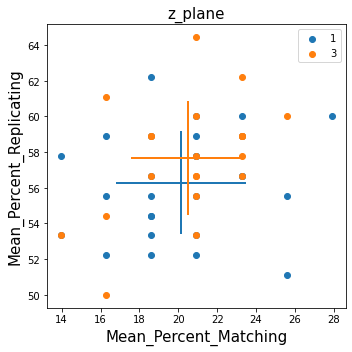

In [5]:
# B

group = "z_plane"

df_subset = match_rep_df[(match_rep_df["sphering"] == True) & (match_rep_df["Vendor"] == "PE") & (match_rep_df["Modality"] == "Confocal")]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig, 
    ax_=ax
)
fig.savefig("(B)-rep-vs-match-z_plane-PE-confocal.png")

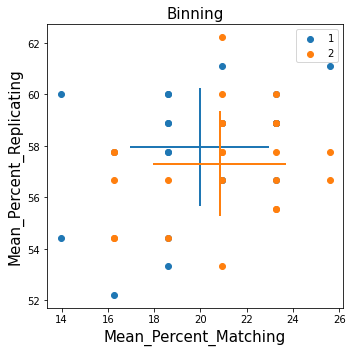

In [6]:
# C

group = "Binning"

df_subset = match_rep_df[(match_rep_df["sphering"] == True) & (match_rep_df["Vendor"] == "PE") & (match_rep_df["Modality"] == "Widefield")]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig, 
    ax_=ax
)
fig.savefig("(C)-rep-vs-match-binning-PE-widefield.png")

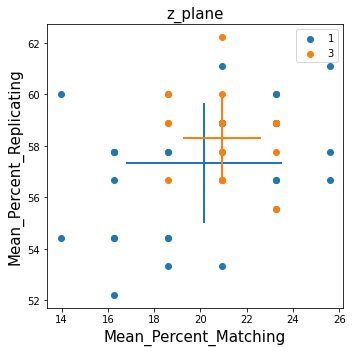

In [7]:
# D

group = "z_plane"

df_subset = match_rep_df[(match_rep_df["sphering"] == True) & (match_rep_df["Vendor"] == "PE") & (match_rep_df["Modality"] == "Widefield")]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig, 
    ax_=ax
)
fig.savefig("(B)-rep-vs-match-z_plane-PE-widefield.png")

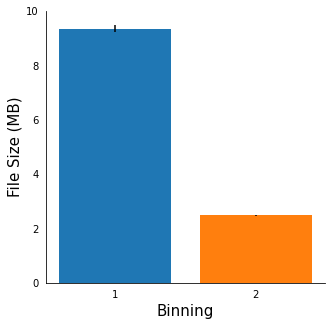

In [10]:
# E

df_subset = match_rep_df[(~match_rep_df["Batch"].str.contains("siteSubSample")) & (match_rep_df["sphering"] == True) & (match_rep_df["Vendor"] == "PE")]

additional_cols = {
    "col1": ["Size_MB", "Mean_Size_MB", lambda x: np.mean(x)],
    "col2": ["Size_MB", "std_Size_MB", lambda z: float('%.3f'%np.std(z))]
}
group_df = utilssphering.find_group_avg_df(df_subset, "Binning", add_cols=additional_cols)
group_df

cmap = plt.cm.tab10
colour_palette = list()
for i in range(cmap.N):
    colour_palette.append(cmap(i))

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(group_df["Binning"], group_df["Mean_Size_MB"], yerr=group_df["std_Size_MB"], color=[colour_palette[0], colour_palette[1]])
ax.set_xticks(group_df["Binning"], group_df["Binning"])
ax.set_xlabel("Binning", fontsize=15)
ax.set_ylabel("File Size (MB)", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", which="both", bottom=False, left=False)
ax.yaxis.set_ticks(np.arange(0, 11, 2))
fig.set_facecolor("white")

fig.savefig("(E)-file_size-vs-binning-PE_only.png")